In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [153]:
pip install git+git://github.com/VIDA-NYU/openclean.git

  Cloning git://github.com/VIDA-NYU/openclean.git to /tmp/pip-req-build-3e5uep2e
  Running command git clone -q git://github.com/VIDA-NYU/openclean.git /tmp/pip-req-build-3e5uep2e
  Running command git submodule update --init --recursive -q
  Created wheel for openclean: filename=openclean-0.1.0-cp37-none-any.whl size=4897 sha256=a4babdba8001ad912d72360b8db254c23e638039c8f4c17f6a974c8417c5503e
  Stored in directory: /tmp/pip-ephem-wheel-cache-szf4jnmb/wheels/5f/de/0d/3f94f0323cd128a09f597f9c646d4d57e62845deb0136fb223
Successfully built openclean


## Import data

In [154]:
# Initialize dataframe with MTA data file from 03/20/2021
mta_df = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_210320.txt")

# Encode day of week
mta_df['DATE'] = pd.to_datetime(mta_df['DATE'], format="%m/%d/%Y")
# mta_df['DAY'] = mta_df['DATE'].apply(lambda x: x.weekday())

# # Remove weekdays
# mta_df = mta_df[(mta_df['DAY'] == 5) | (mta_df['DAY'] == 6)]

In [155]:
## Read in rest of MTA data, dating back to 01/02/2020 (earliest date in COVID database)

# Earliest date in COVID database
start_date = datetime(2020, 1, 2)
# Up to initial date of mta_df
end_date = datetime(2021, 3, 19)

# Concatenate data files
for i in range(int((end_date - start_date).days)):
  curr_date = end_date - timedelta(i)
  
  try:
    # Read in current data file
    curr_df = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt".format(curr_date.strftime("%y%m%d")))
    # Remove weekdays
    curr_df['DATE'] = pd.to_datetime(curr_df['DATE'], format="%m/%d/%Y")
    # curr_df['DAY'] = curr_df['DATE'].apply(lambda x: x.weekday())
    # curr_df = curr_df[(curr_df['DAY'] == 5) | (curr_df['DAY'] == 6)]
  except:
    continue
  
  # Concatenate data files
  mta_df = pd.concat([mta_df, curr_df], axis=0)

## Preliminary data profiling & cleaning

In [156]:
# Check rows
mta_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-03-13,03:00:00,REGULAR,7543925,2573549
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-03-13,07:00:00,REGULAR,7543931,2573559
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-03-13,11:00:00,REGULAR,7543970,2573622
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-03-13,15:00:00,REGULAR,7544072,2573700
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2021-03-13,19:00:00,REGULAR,7544219,2573729


In [157]:
# Check info
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13330595 entries, 0 to 206498
Data columns (total 11 columns):
 #   Column                                                                Dtype         
---  ------                                                                -----         
 0   C/A                                                                   object        
 1   UNIT                                                                  object        
 2   SCP                                                                   object        
 3   STATION                                                               object        
 4   LINENAME                                                              object        
 5   DIVISION                                                              object        
 6   DATE                                                                  datetime64[ns]
 7   TIME                                                                  ob

In [158]:
# Convert column names to lowercase & strip whitespace
mta_df.rename(columns=lambda x: x.lower().rstrip(), inplace=True)

In [159]:
# Reset index values
mta_df = mta_df.reset_index(drop=True)

In [160]:
# Confirm formatting changes
mta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13330595 entries, 0 to 13330594
Data columns (total 11 columns):
 #   Column    Dtype         
---  ------    -----         
 0   c/a       object        
 1   unit      object        
 2   scp       object        
 3   station   object        
 4   linename  object        
 5   division  object        
 6   date      datetime64[ns]
 7   time      object        
 8   desc      object        
 9   entries   int64         
 10  exits     int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 1.1+ GB


In [161]:
# Extract min date
mta_df['date'].min()

Timestamp('2019-12-28 00:00:00')

In [162]:
# Remove records whose dates go back too far
mta_df = mta_df[mta_df['date'] >= datetime(2020, 1, 2)]

In [163]:
# Confirm acceptable min date
mta_df['date'].min()

Timestamp('2020-01-02 00:00:00')

In [164]:
# Inspect station names
pd.set_option('max_rows', None)
mta_df['station'].value_counts()

34 ST-PENN STA     266676
FULTON ST          256070
GRD CNTRL-42 ST    214262
23 ST              193872
86 ST              170689
CANAL ST           153816
CHAMBERS ST        145630
34 ST-HERALD SQ    144036
59 ST              136657
42 ST-PORT AUTH    135380
14 ST              135314
ATL AV-BARCLAY     133386
WALL ST            131817
TIMES SQ-42 ST     117402
125 ST             113919
PATH NEW WTC       113640
14 ST-UNION SQ     109069
59 ST COLUMBUS     108924
CORTLANDT ST       103357
28 ST              102942
JAY ST-METROTEC    100603
CHURCH AV           98422
96 ST               98356
161/YANKEE STAD     98240
47-50 STS ROCK      96560
50 ST               95751
METS-WILLETS PT     94401
WTC-CORTLANDT       93011
LEXINGTON AV/53     85150
KINGS HWY           79789
34 ST-HUDSON YD     79121
BOWLING GREEN       77368
72 ST               77103
JAMAICA 179 ST      76736
BOROUGH HALL        72853
FLUSHING-MAIN       69680
8 AV                68695
ST. GEORGE          68332
HARRISON    

In [165]:
# `entries` and `exits` are cumulative counts --> aggregate counts to daily by turnstile
daily_entries_by_turnstile = mta_df.groupby(['c/a', 'unit', 'scp', 'station','date']).max('entries') - mta_df.groupby(['c/a', 'unit', 'scp', 'station','date']).min('entries')
daily_exits_by_turnstile = mta_df.groupby(['c/a', 'unit', 'scp', 'station','date']).max('exits') - mta_df.groupby(['c/a', 'unit', 'scp', 'station','date']).min('exits')

In [166]:
# Flatten dataframes for merge operation
daily_entries_by_turnstile.reset_index(inplace=True)
daily_exits_by_turnstile.reset_index(inplace=True)

In [168]:
# Group by station, date for aggregate daily count by station
daily_traffic_df = pd.merge(daily_entries_by_turnstile, daily_exits_by_turnstile, how='outer').groupby(['station', 'date']).sum().reset_index()

In [169]:
daily_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167522 entries, 0 to 167521
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   station  167522 non-null  object        
 1   date     167522 non-null  datetime64[ns]
 2   entries  167522 non-null  int64         
 3   exits    167522 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.1+ MB


## Data profiling & cleaning with OpenClean

In [170]:
from openclean.pipeline import stream

# Create openclean data stream
ds = stream(daily_traffic_df)

In [171]:
# Check rows
ds.head()

,station,date,entries,exits
0,1 AV,2020-01-02 00:00:00,15135,17646
1,1 AV,2020-01-03 00:00:00,15611,18266
2,1 AV,2020-01-04 00:00:00,6015,7119
3,1 AV,2020-01-05 00:00:00,4724,5530
4,1 AV,2020-01-06 00:00:00,16263,18641
5,1 AV,2020-01-07 00:00:00,16612,19372
6,1 AV,2020-01-08 00:00:00,17206,20275
7,1 AV,2020-01-09 00:00:00,17463,20072
8,1 AV,2020-01-10 00:00:00,17642,20489
9,1 AV,2020-01-11 00:00:00,6971,8220


In [172]:
from openclean.profiling.column import DefaultColumnProfiler

# Profile a sample of 10000 rows from dataset
profile = ds.sample(n=10000, random_state=42).profile(default_profiler=DefaultColumnProfiler)

In [173]:
# Print profiling statistics
profile.stats()

,total,empty,distinct,uniqueness,entropy
station,10000,0,379,0.0379,8.537717
date,10000,0,443,0.0443,8.762064
entries,10000,0,5520,0.5520,12.119437
exits,10000,0,5313,0.5313,12.059419


In [174]:
from openclean.profiling.anomalies.sklearn import DBSCANOutliers

# Search for station entries value outliers
DBSCANOutliers(eps=0.02).find(ds.distinct('entries'))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 1111,
 11111,
 1562922135,
 1895331990,
 419073952,
 11840400,
 3657085530,
 468497510,
 1313111,
 1506677570,
 1621031101,
 631052148,
 12524554,
 12011219,
 10330371,
 1224849851,
 1131003866]

Some of these values are nonsensically large. Let's see if we can filter out impossible values.

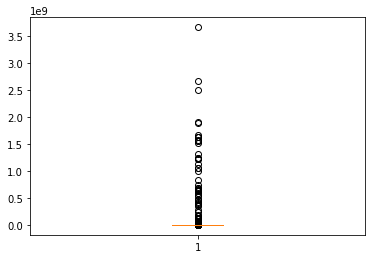

In [175]:
# Visualize entries values
plt.boxplot(daily_traffic_df['entries'])
plt.show()

In [176]:
# 8 million people in NYC -> unlikely all of them pass through a single station on a single day. Set 8M as upper bound
daily_traffic_df = daily_traffic_df[daily_traffic_df['entries'] <= 800000]

# Refresh data stream
ds = stream(daily_traffic_df)

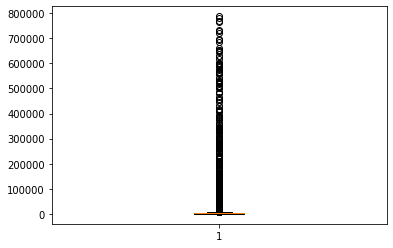

In [177]:
# Re-visualize outliers
plt.boxplot(daily_traffic_df['entries'])
plt.show()

In [180]:
# Search for remaining station entries value outliers
DBSCANOutliers().find(ds.distinct('entries'))

[0]

In [181]:
# Search for station exits value outliers
DBSCANOutliers(eps=0.02).find(ds.distinct('exits'))

[0,
 1,
 1056966762,
 11111,
 4194640,
 22222,
 536872013,
 4488013,
 1222150,
 1100799,
 3471391,
 6555459,
 17134387,
 285180608,
 2725458,
 1070316087]

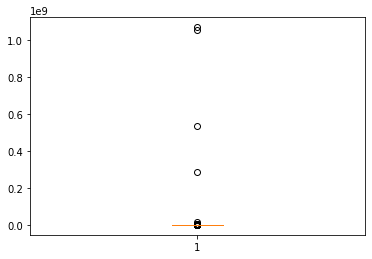

In [182]:
# Visualize exits values
plt.boxplot(daily_traffic_df['exits'])
plt.show()

In [183]:
# Again, set 8M as upper bound
daily_traffic_df = daily_traffic_df[daily_traffic_df['exits'] <= 800000]

# Refresh data stream
ds = stream(daily_traffic_df)

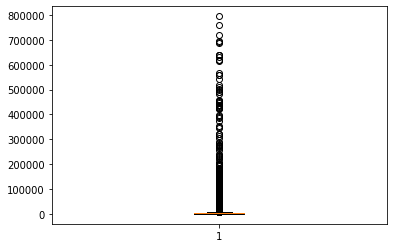

In [184]:
# Re-visualize outliers
plt.boxplot(daily_traffic_df['exits'])
plt.show()

In [185]:
# Search for remaining station exits value outliers
DBSCANOutliers().find(ds.distinct('exits'))

[0]

In [189]:
daily_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167195 entries, 0 to 167521
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   station  167195 non-null  object        
 1   date     167195 non-null  datetime64[ns]
 2   entries  167195 non-null  int64         
 3   exits    167195 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.4+ MB


## Basic visulaizations

In [186]:
# Group by date for time-series analysis
total_traffic_df = daily_traffic_df.groupby('date').sum().reset_index()

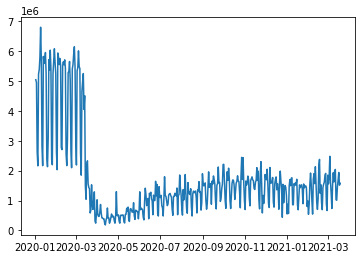

In [187]:
# Plot entries over time
plt.plot('date', 'entries', data=total_traffic_df)

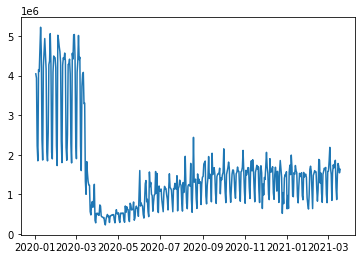

In [188]:
# Plot exits over time
plt.plot('date', 'exits', data=total_traffic_df)